# Does negativity make success?

In [1]:
import pandas as pd
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.formula.api as smf
import scipy

import warnings
warnings.filterwarnings("ignore")

#### Load the dataframe containing videos from 2019 and their features

This is a big file (860 MB) so we have stored it on Google Drive. Download it from the link below and storie it as `generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet`. It was generated by the notebook `data_processing.ipynb`.

https://drive.google.com/file/d/1RmVSw2MBq0Ps0dwcTQjqZsDAuivXbUaZ/view?usp=share_link

In [2]:
filepath = 'generated/2019/2019_videos_Typo_Emojis_NegWords_Sentiment_title_desc.parquet'
videos = pd.read_parquet(filepath, engine='fastparquet')

In [3]:
videos.columns

Index(['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'count_words_title', 'count_negative_words_title',
       'count_words_description', 'count_negative_words_description',
       'sia_negative_title', 'sia_neutral_title', 'sia_positive_title',
       'sia_compound_title', 'count_negative_emojis_title',
       'count_upper_words_title', 'count_excl_marks_title',
       'count_upper_words_description', 'count_excl_marks_description',
       'count_negative_emojis_description', 'sia_negative_description',
       'sia_neutral_description', 'sia_positive_description',
       'sia_compound_description'],
      dtype='object')

## What is negativity?

### Small intro (examples with sia from vader)

In [4]:
usvideos_1718 = pd.read_csv('data/USvideos 2.csv')
usvideos_2022 = pd.read_csv('data/US_youtube_trending_data 2.csv')


usvideos_1718 = usvideos_1718.drop('video_error_or_removed', axis=1)


usvideos_2022 = usvideos_2022.drop('channelId', axis=1)


usvideos_2022.rename(columns = {'publishedAt':'publish_time','channelTitle':'channel_title', 'categoryId':'category_id', 'view_count':'views'}, inplace = True)

columns_titles = usvideos_2022.columns

columns_titles_bis = []
columns_titles_bis.append(columns_titles[0])
columns_titles_bis.append(columns_titles[5])
columns_titles_bis.append(columns_titles[1])
columns_titles_bis.append(columns_titles[3])
columns_titles_bis.append(columns_titles[4])
columns_titles_bis.append(columns_titles[2])
columns_titles_bis.append(columns_titles[6])
columns_titles_bis.append(columns_titles[7])
columns_titles_bis.append(columns_titles[8])
columns_titles_bis.append(columns_titles[9])
columns_titles_bis.append(columns_titles[10])
columns_titles_bis.append(columns_titles[11])
columns_titles_bis.append(columns_titles[12])
columns_titles_bis.append(columns_titles[13])
columns_titles_bis.append(columns_titles[14])
usvideos_1718.columns

usvideos_2022=usvideos_2022.reindex(columns=columns_titles_bis)

df_trends = pd.concat(
    [usvideos_1718, usvideos_2022],
    axis=0,
    join="outer",
    ignore_index=True,
    keys=None,
    levels=None,
    names=None,
    verify_integrity=False,
    copy=True,
)

df_trends

,video_id,trending_date,title,channel_title,category_id,publish_time,tags,views,likes,dislikes,comment_count,thumbnail_link,comments_disabled,ratings_disabled,description
0,2kyS6SvSYSE,17.14.11,WE WANT TO TALK ABOUT OUR MARRIAGE,CaseyNeistat,22,2017-11-13T17:13:01.000Z,SHANtell martin,748374,57527,2966,15954,https://i.ytimg.com/vi/2kyS6SvSYSE/default.jpg,False,False,SHANTELL'S CHANNEL - https://www.youtube.com/s...
1,1ZAPwfrtAFY,17.14.11,The Trump Presidency: Last Week Tonight with J...,LastWeekTonight,24,2017-11-13T07:30:00.000Z,"last week tonight trump presidency|""last week ...",2418783,97185,6146,12703,https://i.ytimg.com/vi/1ZAPwfrtAFY/default.jpg,False,False,"One year after the presidential election, John..."
2,5qpjK5DgCt4,17.14.11,"Racist Superman | Rudy Mancuso, King Bach & Le...",Rudy Mancuso,23,2017-11-12T19:05:24.000Z,"racist superman|""rudy""|""mancuso""|""king""|""bach""...",3191434,146033,5339,8181,https://i.ytimg.com/vi/5qpjK5DgCt4/default.jpg,False,False,WATCH MY PREVIOUS VIDEO ▶ \n\nSUBSCRIBE ► http...
3,puqaWrEC7tY,17.14.11,Nickelback Lyrics: Real or Fake?,Good Mythical Morning,24,2017-11-13T11:00:04.000Z,"rhett and link|""gmm""|""good mythical morning""|""...",343168,10172,666,2146,https://i.ytimg.com/vi/puqaWrEC7tY/default.jpg,False,False,Today we find out if Link is a Nickelback amat...
4,d380meD0W0M,17.14.11,I Dare You: GOING BALD!?,nigahiga,24,2017-11-12T18:01:41.000Z,"ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""...",2095731,132235,1989,17518,https://i.ytimg.com/vi/d380meD0W0M/default.jpg,False,False,I know it's been a while since we did this sho...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
207534,o_oenl2Be-w,2022-11-18T00:00:00Z,Wizkid - 2 Sugar (feat. Ayra Starr) (Official ...,StarBoy TV,10,2022-11-11T19:14:33Z,Afrobeat|Hip Hop|Wizkid|Made In Lagos|Nigeria|...,2161075,75596,0,3227,https://i.ytimg.com/vi/o_oenl2Be-w/default.jpg,False,False,Wizkid - 2 Sugar (feat. Ayra Starr) (Official ...
207535,DWBaf5U6vQQ,2022-11-18T00:00:00Z,Alex Pereira Octagon Interview | UFC 281,UFC - Ultimate Fighting Championship,17,2022-11-13T06:21:30Z,ufc|mma|ultimate fighting championship|UFC 281...,1874052,28533,0,7066,https://i.ytimg.com/vi/DWBaf5U6vQQ/default.jpg,False,False,Newly crowned middleweight champion Alex Perei...
207536,1V1ZrKOeXic,2022-11-18T00:00:00Z,How Asian Parents Grocery Shop,Steven He,23,2022-11-11T19:13:00Z,Steven He|Comedy|Sketches|Funny|laugh|tntl|ski...,2034736,96623,0,4307,https://i.ytimg.com/vi/1V1ZrKOeXic/default.jpg,False,False,Go to https://establishedtitles.com/StevenHe a...
207537,SXrcyqCPu4E,2022-11-18T00:00:00Z,Rod Wave - Break My Heart (Official Video),RodWave,10,2022-11-10T05:00:08Z,rod wave|hunger games|hunger games 3|ptsd|ghet...,3554744,135813,0,4589,https://i.ytimg.com/vi/SXrcyqCPu4E/default.jpg,False,False,Pre-Save Rod Wave's New Project Jupiter Diarie...


In [5]:
treshold_views = np.quantile(df_trends['views'], 0.4)
treshold_likes = np.quantile(df_trends['likes'], 0.4)
treshold_likes
treshold_views


697505.0000000001

In [6]:
videos_success = videos.loc[(videos['view_count'] > treshold_views)]
videos_success = videos_success.loc[(videos_success['like_count'] > treshold_likes)]
videos_success

,categories,channel_id,crawl_date,dislike_count,display_id,duration,like_count,upload_date,view_count,count_words_title,...,count_negative_emojis_title,count_upper_words_title,count_excl_marks_title,count_upper_words_description,count_excl_marks_description,count_negative_emojis_description,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description
47,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.405938,613,BDnF-EgqAGw,398,49464,2019-02-05,1142835,8,...,0,1,0,0,0,0,0.291,0.485,0.223,-0.1779
48,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:30.959894,588,wrTIXbQED80,375,32726,2019-01-31,819654,4,...,0,0,0,0,0,0,0.000,1.000,0.000,0.0000
49,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.467288,1177,uyWL0ZWibyU,335,86222,2019-01-22,2159837,4,...,0,0,0,0,0,0,0.093,0.659,0.249,0.6369
50,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:31.948318,673,yd7d51AgSso,319,30596,2019-01-15,736707,4,...,0,0,0,0,0,0,0.000,0.597,0.403,0.7968
51,People & Blogs,UCzWmWTPCafQRNl9q9Y53AfQ,2019-11-17 05:07:32.579907,991,-Ia18bqO-9w,367,75504,2019-01-09,1636316,4,...,0,0,0,0,0,0,0.000,0.784,0.216,0.2960
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12722465,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:40:14.207309,13759,-6tb2e8o9P4,5530,166341,2019-05-04,6563179,10,...,0,2,0,0,1,0,0.000,1.000,0.000,0.0000
12722777,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:37.982711,1700,eyfxhuqlQYU,12707,31815,2019-09-22,1068786,10,...,0,2,0,2,1,0,0.000,1.000,0.000,0.0000
12723042,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:42.845914,2606,A-2b0SVFCog,7627,35683,2019-08-14,1970503,18,...,0,1,0,1,1,0,0.000,1.000,0.000,0.0000
12723069,News & Politics,UCrwE8kVqtIUVUzKui2WVpuQ,2019-11-01 23:38:46.554592,3916,PZ0m1EmpndU,2411,67373,2019-08-08,2462660,12,...,0,1,0,1,1,0,0.000,1.000,0.000,0.0000


In [7]:
new_videos = videos.drop(videos_success.index)

In [8]:
videos_success.categories.unique()

array(['People & Blogs', 'Science & Technology', 'Gaming',
       'Film & Animation', 'News & Politics', 'Howto & Style', 'Music',
       'Entertainment', 'Education', 'Comedy', 'Travel & Events',
       'Sports', 'Autos & Vehicles', 'Pets & Animals',
       'Nonprofits & Activism', None], dtype=object)

In [9]:
sia_neg_title_success = videos_success[['sia_negative_title', 'categories']]
sia_pos_title_success = videos_success[['sia_positive_title','categories']]
sia_neu_title_success = videos_success[['sia_neutral_title', 'categories']]

sia_neg_description_success = videos_success[['sia_negative_description', 'categories']]
sia_pos_description_success = videos_success[['sia_positive_description', 'categories']]
sia_neu_description_success = videos_success[['sia_neutral_description', 'categories']]

sia_neg_title = new_videos[['sia_negative_title', 'categories']]
sia_pos_title = new_videos[['sia_positive_title', 'categories']]
sia_neu_title = new_videos[['sia_neutral_title', 'categories']]

sia_neg_description = new_videos[['sia_negative_description', 'categories']]
sia_pos_description = new_videos[['sia_positive_description', 'categories']]
sia_neu_description = new_videos[['sia_neutral_description', 'categories']]

print(sia_neg_title_success)

# print(np.var(sia_neg_title_success))
# print(np.var(sia_neg_title))

# print(np.var(sia_pos_title_success))
# print(np.var(sia_pos_title))

# print(np.var(sia_neu_title_success))
# print(np.var(sia_neu_title))

# print(np.var(sia_neg_description_success))
# print(np.var(sia_neg_description))

# print(np.var(sia_pos_description_success))
# print(np.var(sia_pos_description))

# print(np.var(sia_neu_description_success))
# print(np.var(sia_neu_description))


          sia_negative_title       categories
47                     0.314   People & Blogs
48                     0.000   People & Blogs
49                     0.552   People & Blogs
50                     0.000   People & Blogs
51                     0.000   People & Blogs
...                      ...              ...
12722465               0.000  News & Politics
12722777               0.000  News & Politics
12723042               0.000  News & Politics
12723069               0.000  News & Politics
12723110               0.000  News & Politics

[85365 rows x 2 columns]


In [10]:
neg_title_suc = ['Negative sentiment']
sia_bool_neg_title_suc = ['successful']

neg_title_suc = neg_title_suc*len(sia_neg_title_success)
sia_bool_neg_title_suc = sia_bool_neg_title_suc*len(sia_neg_title_success)
neg_title_suc_cat = sia_neg_title_success['categories']
sia_neg_title_success = sia_neg_title_success['sia_negative_title']



In [11]:
neg_title_suc

sia_neg_title_success_values = sia_neg_title_success.values
sia_neg_title_success = sia_neg_title_success_values.tolist()
type(sia_neg_title_success)


list

In [12]:

data_given = {'Type of sentiment': neg_title_suc, 'SIA value': sia_neg_title_success, "Video's succes": sia_bool_neg_title_suc, 'categories':neg_title_suc_cat}

neg_title_suc_df = pd.DataFrame(data = data_given)
neg_title_suc_df

,Type of sentiment,SIA value,Video's succes,categories
47,Negative sentiment,0.314,successful,People & Blogs
48,Negative sentiment,0.000,successful,People & Blogs
49,Negative sentiment,0.552,successful,People & Blogs
50,Negative sentiment,0.000,successful,People & Blogs
51,Negative sentiment,0.000,successful,People & Blogs
...,...,...,...,...
12722465,Negative sentiment,0.000,successful,News & Politics
12722777,Negative sentiment,0.000,successful,News & Politics
12723042,Negative sentiment,0.000,successful,News & Politics
12723069,Negative sentiment,0.000,successful,News & Politics


In [13]:
neg_title = ['Negative sentiment']
sia_bool_neg_title = ['not successful']

neg_title = neg_title*len(sia_neg_title)
sia_bool_neg_title = sia_bool_neg_title*len(sia_neg_title)
neg_title_cat = sia_neg_title['categories']
sia_neg_title = sia_neg_title['sia_negative_title']

In [14]:
sia_neg_title_values = sia_neg_title.values
sia_neg_title = sia_neg_title_values.tolist()
type(sia_neg_title)

list

In [15]:
data_given = {'Type of sentiment': neg_title, 'SIA value': sia_neg_title, "Video's succes": sia_bool_neg_title, 'categories':neg_title_cat}

neg_title_df = pd.DataFrame(data = data_given)



In [16]:
neg_title_total_df = neg_title_suc_df.append(neg_title_df, ignore_index=True)

neg_title_total_df

,Type of sentiment,SIA value,Video's succes,categories
0,Negative sentiment,0.314,successful,People & Blogs
1,Negative sentiment,0.000,successful,People & Blogs
2,Negative sentiment,0.552,successful,People & Blogs
3,Negative sentiment,0.000,successful,People & Blogs
4,Negative sentiment,0.000,successful,People & Blogs
...,...,...,...,...
12723119,Negative sentiment,0.000,not successful,News & Politics
12723120,Negative sentiment,0.000,not successful,News & Politics
12723121,Negative sentiment,0.000,not successful,News & Politics
12723122,Negative sentiment,0.000,not successful,News & Politics


In [17]:
pos_title_suc = ['Positive sentiment']
sia_bool_pos_title_suc = ['successful']

pos_title_suc = pos_title_suc*len(sia_pos_title_success)
sia_bool_pos_title_suc = sia_bool_pos_title_suc*len(sia_pos_title_success)
pos_title_suc_cat = sia_pos_title_success['categories']
sia_pos_title_success = sia_pos_title_success['sia_positive_title']

In [18]:
sia_pos_title_success_values = sia_pos_title_success.values
sia_pos_title_success = sia_pos_title_success_values.tolist()
type(sia_pos_title_success)

list

In [19]:
data_given = {'Type of sentiment': pos_title_suc, 'SIA value': sia_pos_title_success, "Video's succes": sia_bool_pos_title_suc, 'categories':pos_title_suc_cat}

pos_title_suc_df = pd.DataFrame(data = data_given)
pos_title_suc_df

,Type of sentiment,SIA value,Video's succes,categories
47,Positive sentiment,0.0,successful,People & Blogs
48,Positive sentiment,0.0,successful,People & Blogs
49,Positive sentiment,0.0,successful,People & Blogs
50,Positive sentiment,0.0,successful,People & Blogs
51,Positive sentiment,0.0,successful,People & Blogs
...,...,...,...,...
12722465,Positive sentiment,0.0,successful,News & Politics
12722777,Positive sentiment,0.0,successful,News & Politics
12723042,Positive sentiment,0.0,successful,News & Politics
12723069,Positive sentiment,0.0,successful,News & Politics


In [20]:
pos_title = ['Positive sentiment']
sia_bool_pos_title = ['not successful']

pos_title = pos_title*len(sia_pos_title)
sia_bool_pos_title = sia_bool_pos_title*len(sia_pos_title)
pos_title_cat = sia_pos_title['categories']
sia_pos_title = sia_pos_title['sia_positive_title']

In [21]:

sia_pos_title_values = sia_pos_title.values
sia_pos_title = sia_pos_title_values.tolist()
type(sia_pos_title)

list

In [22]:
data_given = {'Type of sentiment': pos_title, 'SIA value': sia_pos_title, "Video's succes": sia_bool_pos_title, 'categories':pos_title_cat}

pos_title_df = pd.DataFrame(data = data_given)

In [23]:
pos_title_total_df = pos_title_suc_df.append(pos_title_df, ignore_index=True)

pos_title_total_df

,Type of sentiment,SIA value,Video's succes,categories
0,Positive sentiment,0.000,successful,People & Blogs
1,Positive sentiment,0.000,successful,People & Blogs
2,Positive sentiment,0.000,successful,People & Blogs
3,Positive sentiment,0.000,successful,People & Blogs
4,Positive sentiment,0.000,successful,People & Blogs
...,...,...,...,...
12723119,Positive sentiment,0.403,not successful,News & Politics
12723120,Positive sentiment,0.351,not successful,News & Politics
12723121,Positive sentiment,0.351,not successful,News & Politics
12723122,Positive sentiment,0.375,not successful,News & Politics


In [24]:
neu_title_suc = ['Neutral sentiment']
sia_bool_neu_title_suc = ['successful']

neu_title_suc = neu_title_suc*len(sia_neu_title_success)
sia_bool_neu_title_suc = sia_bool_neu_title_suc*len(sia_neu_title_success)
neu_title_suc_cat = sia_neu_title_success['categories']
sia_neu_title_success = sia_neu_title_success['sia_neutral_title']

In [25]:
sia_neu_title_success_values = sia_neu_title_success.values
sia_neu_title_success = sia_neu_title_success_values.tolist()
type(sia_neu_title_success)

list

In [26]:
data_given = {'Type of sentiment': neu_title_suc, 'SIA value': sia_neu_title_success, "Video's succes": sia_bool_neu_title_suc, 'categories':neu_title_suc_cat}

neu_title_suc_df = pd.DataFrame(data = data_given)
neu_title_suc_df

,Type of sentiment,SIA value,Video's succes,categories
47,Neutral sentiment,0.686,successful,People & Blogs
48,Neutral sentiment,1.000,successful,People & Blogs
49,Neutral sentiment,0.448,successful,People & Blogs
50,Neutral sentiment,1.000,successful,People & Blogs
51,Neutral sentiment,1.000,successful,People & Blogs
...,...,...,...,...
12722465,Neutral sentiment,1.000,successful,News & Politics
12722777,Neutral sentiment,1.000,successful,News & Politics
12723042,Neutral sentiment,1.000,successful,News & Politics
12723069,Neutral sentiment,1.000,successful,News & Politics


In [27]:
neu_title = ['Neutral sentiment']
sia_bool_neu_title = ['not successful']

neu_title = neu_title*len(sia_neu_title)
sia_bool_neu_title = sia_bool_neu_title*len(sia_neu_title)
neu_title_cat = sia_neu_title['categories']
sia_neu_title = sia_neu_title['sia_neutral_title']

In [28]:
sia_neu_title_values = sia_neu_title.values
sia_neu_title = sia_neu_title_values.tolist()
type(sia_neu_title)

list

In [29]:
data_given = {'Type of sentiment': neu_title, 'SIA value': sia_neu_title, "Video's succes": sia_bool_neu_title, 'categories':neu_title_cat}

neu_title_df = pd.DataFrame(data = data_given)

In [30]:
neu_title_total_df = neu_title_suc_df.append(neu_title_df, ignore_index=True)

neu_title_total_df

,Type of sentiment,SIA value,Video's succes,categories
0,Neutral sentiment,0.686,successful,People & Blogs
1,Neutral sentiment,1.000,successful,People & Blogs
2,Neutral sentiment,0.448,successful,People & Blogs
3,Neutral sentiment,1.000,successful,People & Blogs
4,Neutral sentiment,1.000,successful,People & Blogs
...,...,...,...,...
12723119,Neutral sentiment,0.597,not successful,News & Politics
12723120,Neutral sentiment,0.649,not successful,News & Politics
12723121,Neutral sentiment,0.649,not successful,News & Politics
12723122,Neutral sentiment,0.625,not successful,News & Politics


In [31]:
title_total_df = neg_title_total_df.append([pos_title_total_df,neu_title_total_df], ignore_index=True)


In [32]:

title_total_df

,Type of sentiment,SIA value,Video's succes,categories
0,Negative sentiment,0.314,successful,People & Blogs
1,Negative sentiment,0.000,successful,People & Blogs
2,Negative sentiment,0.552,successful,People & Blogs
3,Negative sentiment,0.000,successful,People & Blogs
4,Negative sentiment,0.000,successful,People & Blogs
...,...,...,...,...
38169367,Neutral sentiment,0.597,not successful,News & Politics
38169368,Neutral sentiment,0.649,not successful,News & Politics
38169369,Neutral sentiment,0.649,not successful,News & Politics
38169370,Neutral sentiment,0.625,not successful,News & Politics


Text(0.5, 1.0, 'Difference in the SIA value in the title depending on the succes of the video')

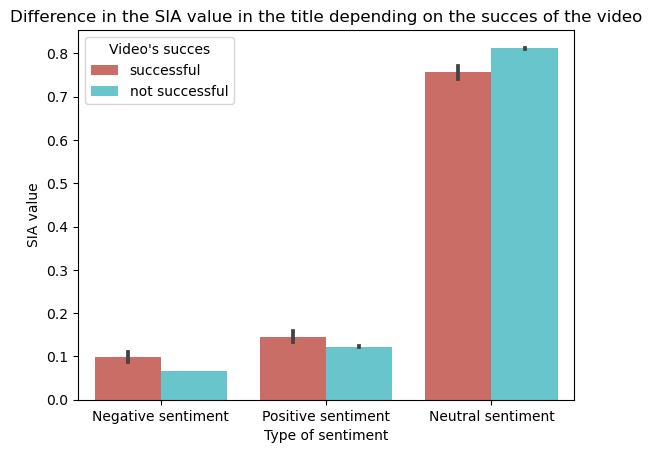

In [33]:
sns.barplot(data=title_total_df.loc[title_total_df['categories'] == 'Pets & Animals'], x="Type of sentiment", y="SIA value", hue="Video's succes", color = 'blue', palette = 'hls')
plt.title('Difference in the SIA value in the title depending on the succes of the video')

In [34]:
from dash import Dash, dcc, html, Input, Output
import plotly.express as px


In [35]:
print(px.data.__file__)

/Users/matteopeduto/opt/anaconda3/envs/ada/lib/python3.9/site-packages/plotly/express/data/__init__.py


In [36]:
for name in dir(px.data):
    if '__' not in name:
        print(name)

absolute_import
carshare
election
election_geojson
experiment
gapminder
iris
medals_long
medals_wide
stocks
tips
wind


In [42]:

from jupyter_dash import JupyterDash
import dash_html_components as html
import dash_core_components as dcc
import plotly.graph_objs as go
import plotly.express as px
import dash


In [43]:


app = JupyterDash(__name__)


app.layout = html.Div([
    html.H4('Difference in the SIA value in the title depending on the succes of the video'),
    dcc.Dropdown(
        id="dropdown",
        options=['People & Blogs', 'Science & Technology', 'Gaming',
       'Film & Animation', 'News & Politics', 'Howto & Style', 'Music',
       'Entertainment', 'Education', 'Comedy', 'Travel & Events',
       'Sports', 'Autos & Vehicles', 'Pets & Animals',
       'Nonprofits & Activism'],
        value="People & Blogs",
        clearable=False,
    ),
    dcc.Graph(id="graph"),
])


@app.callback(
    Output("graph", "figure"), 
    Input("dropdown", "value"))
def update_bar_chart(cat):
    df = title_total_df[:1000] # replace with your own data source
    mask = df["categories"] == cat
    fig = px.bar(df[mask], x="Type of sentiment", y="SIA value", 
                 color="Video's succes", barmode="group")
    return fig


app.run_server(debug = True, mode= 'external',port=8050)

Address already in use
Port 8050 is in use by another program. Either identify and stop that program, or start the server with a different port.


In [ ]:
neg_description_suc = ['Negative sentiment']
sia_bool_neg_description_suc = ['successful']

neg_description_suc = neg_description_suc*len(sia_neg_description_success)
sia_bool_neg_description_suc = sia_bool_neg_description_suc*len(sia_neg_description_success)

In [ ]:
sia_neg_description_success_values = sia_neg_description_success.values
sia_neg_description_success = sia_neg_description_success_values.tolist()

In [ ]:

data_given = {'Type of sentiment': neg_description_suc, 'SIA value': sia_neg_description_success, "Video's succes": sia_bool_neg_description_suc}

neg_description_suc_df = pd.DataFrame(data = data_given)
neg_description_suc_df

,Type of sentiment,SIA value,Video's succes
0,Negative sentiment,0.291,successful
1,Negative sentiment,0.000,successful
2,Negative sentiment,0.093,successful
3,Negative sentiment,0.000,successful
4,Negative sentiment,0.000,successful
...,...,...,...
85360,Negative sentiment,0.000,successful
85361,Negative sentiment,0.000,successful
85362,Negative sentiment,0.000,successful
85363,Negative sentiment,0.000,successful


In [ ]:
neg_description = ['Negative sentiment']
sia_bool_neg_description = ['not successful']

neg_description = neg_description*len(sia_neg_description)
sia_bool_neg_description = sia_bool_neg_description*len(sia_neg_description)

In [ ]:
sia_neg_description_values = sia_neg_description.values
sia_neg_description = sia_neg_description_values.tolist()

In [ ]:
data_given = {'Type of sentiment': neg_description, 'SIA value': sia_neg_description, "Video's succes": sia_bool_neg_description}

neg_description_df = pd.DataFrame(data = data_given)
neg_description_df

,Type of sentiment,SIA value,Video's succes
0,Negative sentiment,0.000,not successful
1,Negative sentiment,0.000,not successful
2,Negative sentiment,0.047,not successful
3,Negative sentiment,0.000,not successful
4,Negative sentiment,0.033,not successful
...,...,...,...
12637754,Negative sentiment,0.000,not successful
12637755,Negative sentiment,0.000,not successful
12637756,Negative sentiment,0.000,not successful
12637757,Negative sentiment,0.000,not successful


In [ ]:
neg_description_total_df = neg_description_suc_df.append(neg_description_df, ignore_index=True)

neg_description_total_df

,Type of sentiment,SIA value,Video's succes
0,Negative sentiment,0.291,successful
1,Negative sentiment,0.000,successful
2,Negative sentiment,0.093,successful
3,Negative sentiment,0.000,successful
4,Negative sentiment,0.000,successful
...,...,...,...
12723119,Negative sentiment,0.000,not successful
12723120,Negative sentiment,0.000,not successful
12723121,Negative sentiment,0.000,not successful
12723122,Negative sentiment,0.000,not successful


In [ ]:
pos_description_suc = ['Positive sentiment']
sia_bool_pos_description_suc = ['successful']

pos_description_suc = pos_description_suc*len(sia_pos_description_success)
sia_bool_pos_description_suc = sia_bool_pos_description_suc*len(sia_pos_description_success)

In [ ]:
sia_pos_description_success_values = sia_pos_description_success.values
sia_pos_description_success = sia_pos_description_success_values.tolist()

In [ ]:

data_given = {'Type of sentiment': pos_description_suc, 'SIA value': sia_pos_description_success, "Video's succes": sia_bool_pos_description_suc}

pos_description_suc_df = pd.DataFrame(data = data_given)
pos_description_suc_df

,Type of sentiment,SIA value,Video's succes
0,Positive sentiment,0.223,successful
1,Positive sentiment,0.000,successful
2,Positive sentiment,0.249,successful
3,Positive sentiment,0.403,successful
4,Positive sentiment,0.216,successful
...,...,...,...
85360,Positive sentiment,0.000,successful
85361,Positive sentiment,0.000,successful
85362,Positive sentiment,0.000,successful
85363,Positive sentiment,0.000,successful


In [ ]:
pos_description = ['Positive sentiment']
sia_bool_pos_description = ['not successful']

pos_description = pos_description*len(sia_pos_description)
sia_bool_pos_description = sia_bool_pos_description*len(sia_pos_description)

In [82]:
sia_pos_description_values = sia_pos_description.values
sia_pos_description = sia_pos_description_values.tolist()

In [83]:
data_given = {'Type of sentiment': pos_description, 'SIA value': sia_pos_description, "Video's succes": sia_bool_pos_description}

pos_description_df = pd.DataFrame(data = data_given)
pos_description_df

,Type of sentiment,SIA value,Video's succes
0,Positive sentiment,0.071,not successful
1,Positive sentiment,0.000,not successful
2,Positive sentiment,0.084,not successful
3,Positive sentiment,0.057,not successful
4,Positive sentiment,0.000,not successful
...,...,...,...
12637754,Positive sentiment,0.206,not successful
12637755,Positive sentiment,0.192,not successful
12637756,Positive sentiment,0.192,not successful
12637757,Positive sentiment,0.198,not successful


In [84]:
pos_description_total_df = pos_description_suc_df.append(pos_description_df, ignore_index=True)

pos_description_total_df

,Type of sentiment,SIA value,Video's succes
0,Positive sentiment,0.223,successful
1,Positive sentiment,0.000,successful
2,Positive sentiment,0.249,successful
3,Positive sentiment,0.403,successful
4,Positive sentiment,0.216,successful
...,...,...,...
12723119,Positive sentiment,0.206,not successful
12723120,Positive sentiment,0.192,not successful
12723121,Positive sentiment,0.192,not successful
12723122,Positive sentiment,0.198,not successful


In [85]:
neu_description_suc = ['Neutral sentiment']
sia_bool_neu_description_suc = ['successful']

neu_description_suc = neu_description_suc*len(sia_neu_description_success)
sia_bool_neu_description_suc = sia_bool_neu_description_suc*len(sia_neu_description_success)

In [86]:
sia_neu_description_success_values = sia_neu_description_success.values
sia_neu_description_success = sia_neu_description_success_values.tolist()

In [87]:
data_given = {'Type of sentiment': neu_description_suc, 'SIA value': sia_neu_description_success, "Video's succes": sia_bool_neu_description_suc}

neu_description_suc_df = pd.DataFrame(data = data_given)
neu_description_suc_df

,Type of sentiment,SIA value,Video's succes
0,Neutral sentiment,0.485,successful
1,Neutral sentiment,1.000,successful
2,Neutral sentiment,0.659,successful
3,Neutral sentiment,0.597,successful
4,Neutral sentiment,0.784,successful
...,...,...,...
85360,Neutral sentiment,1.000,successful
85361,Neutral sentiment,1.000,successful
85362,Neutral sentiment,1.000,successful
85363,Neutral sentiment,1.000,successful


In [88]:
neu_description = ['Neutral sentiment']
sia_bool_neu_description = ['not successful']

neu_description = neu_description*len(sia_neu_description)
sia_bool_neu_description = sia_bool_neu_description*len(sia_neu_description)

In [89]:
sia_neu_description_values = sia_neu_description.values
sia_neu_description = sia_neu_description_values.tolist()

In [90]:
data_given = {'Type of sentiment': neu_description, 'SIA value': sia_neu_description, "Video's succes": sia_bool_neu_description}

neu_description_df = pd.DataFrame(data = data_given)
neu_description_df

,Type of sentiment,SIA value,Video's succes
0,Neutral sentiment,0.929,not successful
1,Neutral sentiment,0.000,not successful
2,Neutral sentiment,0.870,not successful
3,Neutral sentiment,0.943,not successful
4,Neutral sentiment,0.967,not successful
...,...,...,...
12637754,Neutral sentiment,0.794,not successful
12637755,Neutral sentiment,0.808,not successful
12637756,Neutral sentiment,0.808,not successful
12637757,Neutral sentiment,0.802,not successful


In [91]:
neu_description_total_df = neu_description_suc_df.append(neu_description_df, ignore_index=True)

neu_description_total_df

,Type of sentiment,SIA value,Video's succes
0,Neutral sentiment,0.485,successful
1,Neutral sentiment,1.000,successful
2,Neutral sentiment,0.659,successful
3,Neutral sentiment,0.597,successful
4,Neutral sentiment,0.784,successful
...,...,...,...
12723119,Neutral sentiment,0.794,not successful
12723120,Neutral sentiment,0.808,not successful
12723121,Neutral sentiment,0.808,not successful
12723122,Neutral sentiment,0.802,not successful


In [92]:
description_total_df = neg_description_total_df.append([pos_description_total_df,neu_description_total_df], ignore_index=True)

Text(0.5, 1.0, 'Difference in the SIA value in the title depending on the succes of the video')

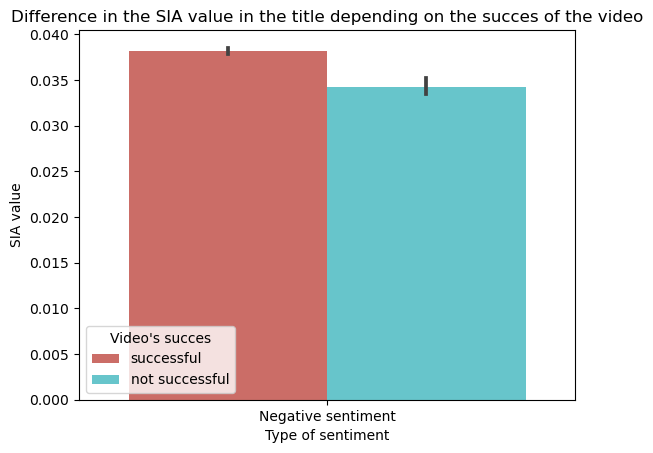

In [93]:
sns.barplot(data=description_total_df[:100000], x="Type of sentiment", y="SIA value", hue="Video's succes", color = 'blue', palette = 'hls')
plt.title('Difference in the SIA value in the title depending on the succes of the video')

In [9]:

neg_title_suc = ['neg_title']

neg_title_suc = neg_title_suc*len(sia_neg_title_success)

pos_title_suc = ['pos_title']

pos_title_suc = pos_title_suc*len(sia_pos_title_success)

neu_title_suc = ['neu_title']

neu_title_suc = neu_title_suc*len(sia_neu_title_success)


neg_description_suc = ['neg_description']

neg_description_suc = neg_description_suc*len(sia_neg_description_success)

pos_description_suc = ['pos_description']

pos_description_suc = pos_description_suc*len(sia_pos_description_success)

neu_description_suc = ['neu_description']

neu_description_suc = neu_description_suc*len(sia_neu_description_success)



neg_title = ['neg_title']

neg_title = neg_title*len(sia_neg_title)

pos_title = ['pos_title']

pos_title = pos_title*len(sia_pos_title)

neu_title = ['neu_title']

neu_title = neu_title*len(sia_neu_title)


neg_description = ['neg_description']

neg_description = neg_description*len(sia_neg_description)

pos_description = ['pos_description']

pos_description = pos_description*len(sia_pos_description)

neu_description = ['neu_description']

neu_description = neu_description*len(sia_neu_description)

neg_title_total = neg_title_suc.append(neg_title)
pos_title_total = pos_title_suc.append(pos_title)
neu_title_total = neu_title_suc.append(neu_title)

neg_description_total = neg_description_suc.append(neg_description)
pos_description_total = pos_description_suc.append(pos_description)
neu_description_total = neu_description_suc.append(neu_description)

neg_title_total
#type_total = neg_title_total.append(pos_title_total, neu_title_total, neg_description_total, pos_description_total, neu_description_total)
print(neg_title_suc)

In [17]:
new_videos.columns

new_videos['dislike_count'].isnull()
new_videos_2 = new_videos.fillna(0)

In [19]:
videos_success['dislike_count'].isnull().sum()

0

In [22]:
new_videos_2['dislike_count'].isnull().sum()

0

In [29]:
dislike_videos = new_videos_2['dislike_count'].mean()
dislike_suc_videos = videos_success['dislike_count'].mean()

In [30]:
dislike_videos

40.24961260932417

In [31]:
dislike_suc_videos


4691.169167691677

In [34]:
a = videos_success['like_count'] -videos_success['dislike_count']
a.mean()

83819.42210507819

In [35]:
b = new_videos_2['like_count'] -new_videos_2['dislike_count']
b.mean()

730.6204832676426

In [27]:
type(sia_neg_title_success)

pandas.core.series.Series

In [ ]:
new_df = {'type': [1, 2], 'col2': [3, 4]}

In [25]:
scipy.stats.ttest_ind(dislike_suc_videos, dislike_videos, axis=0, equal_var=False, alternative='two-sided', trim=0)

ValueError: data type <class 'numpy.object_'> not inexact

In [64]:
scipy.stats.ttest_ind(sia_neg_title_success, sia_neg_title, axis=0, equal_var=False, alternative='two-sided', trim=0)


Ttest_indResult(statistic=41.125253920627465, pvalue=0.0)

In [65]:
print(np.mean(sia_neg_title_success))
print(np.mean(sia_neg_title))

0.08065177766063375
0.059174967413186175


In [66]:
scipy.stats.ttest_ind(sia_pos_title_success, sia_pos_title, axis=0, equal_var=False, alternative='two-sided', trim=0)

Ttest_indResult(statistic=31.29545031329067, pvalue=8.524028453021694e-214)

In [67]:
print(np.mean(sia_pos_title_success))
print(np.mean(sia_pos_title))

0.10227185614713233
0.08446621818010233


In [68]:
scipy.stats.ttest_ind(sia_neu_title_success, sia_neu_title, axis=0, equal_var=False, alternative='two-sided', trim=0)

Ttest_indResult(statistic=-54.02271150988738, pvalue=0.0)

In [69]:
print(np.mean(sia_neu_title_success))
print(np.mean(sia_neu_title))

0.8168889826041192
0.8562248118504756


In [70]:
scipy.stats.ttest_ind(sia_neu_description_success, sia_neu_description, axis=0, equal_var=False, alternative='two-sided', trim=0)

Ttest_indResult(statistic=7.369150894433101, pvalue=1.7321443987365607e-13)

In [71]:
print(np.mean(sia_neu_description_success))
print(np.mean(sia_neu_description))

0.8206710947109371
0.8173838043588072


In [72]:
scipy.stats.ttest_ind(sia_neg_description_success, sia_neg_description, axis=0, equal_var=False, alternative='two-sided', trim=0)

Ttest_indResult(statistic=30.117587090425786, pvalue=3.008945521428552e-198)

In [73]:
print(np.mean(sia_neg_description_success))
print(np.mean(sia_neg_description))

0.038173209160661935
0.03271663797349547


In [74]:
scipy.stats.ttest_ind(sia_pos_description_success, sia_pos_description, axis=0, equal_var=False, alternative='two-sided', trim=0)

Ttest_indResult(statistic=63.40037420861511, pvalue=0.0)

In [75]:
print(np.mean(sia_pos_description_success))
print(np.mean(sia_pos_description))

0.1327418731330146
0.11227007264508412


In [77]:
new_videos.columns

Index(['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'count_words_title', 'count_negative_words_title',
       'count_words_description', 'count_negative_words_description',
       'sia_negative_title', 'sia_neutral_title', 'sia_positive_title',
       'sia_compound_title', 'count_negative_emojis_title',
       'count_upper_words_title', 'count_excl_marks_title',
       'count_upper_words_description', 'count_excl_marks_description',
       'count_negative_emojis_description', 'sia_negative_description',
       'sia_neutral_description', 'sia_positive_description',
       'sia_compound_description'],
      dtype='object')

In [78]:
new_videos = new_videos.drop(columns = ['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'count_words_title', 'count_negative_words_title',
       'count_words_description', 'count_negative_words_description', 'count_negative_emojis_title',
       'count_upper_words_title', 'count_excl_marks_title',
       'count_upper_words_description', 'count_excl_marks_description',
       'count_negative_emojis_description'])

In [79]:
new_videos

,sia_negative_title,sia_neutral_title,sia_positive_title,sia_compound_title,sia_negative_description,sia_neutral_description,sia_positive_description,sia_compound_description
0,0.0,1.000,0.000,0.0000,0.000,0.929,0.071,0.0772
1,0.0,1.000,0.000,0.0000,0.000,0.000,0.000,0.0000
2,0.0,0.734,0.266,0.4404,0.047,0.870,0.084,0.3877
3,0.0,1.000,0.000,0.0000,0.000,0.943,0.057,0.7213
4,0.0,1.000,0.000,0.0000,0.033,0.967,0.000,-0.3664
...,...,...,...,...,...,...,...,...
12723119,0.0,0.597,0.403,0.5267,0.000,0.794,0.206,0.5707
12723120,0.0,0.649,0.351,0.5267,0.000,0.808,0.192,0.5707
12723121,0.0,0.649,0.351,0.5267,0.000,0.808,0.192,0.5707
12723122,0.0,0.625,0.375,0.5267,0.000,0.802,0.198,0.5707


In [80]:
new_videos = new_videos.set_index(['sia_negative_title', 'sia_neutral_title', 'sia_positive_title',
       'sia_compound_title', 'sia_negative_description',
       'sia_neutral_description', 'sia_positive_description',
       'sia_compound_description'])



In [81]:
new_videos

Empty DataFrame
Columns: []
Index: [(0.0, 1.0, 0.0, 0.0, 0.0, 0.929, 0.071, 0.0772), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.734, 0.266, 0.4404, 0.047, 0.87, 0.084, 0.3877), (0.0, 1.0, 0.0, 0.0, 0.0, 0.943, 0.057, 0.7213), (0.0, 1.0, 0.0, 0.0, 0.033, 0.967, 0.0, -0.3664), (0.0, 1.0, 0.0, 0.0, 0.033, 0.967, 0.0, -0.3664), (0.0, 0.874, 0.126, 0.0772, 0.0, 0.889, 0.111, 0.9359), (0.0, 0.791, 0.209, 0.4404, 0.0, 0.815, 0.185, 0.8519), (0.0, 1.0, 0.0, 0.0, 0.038, 0.885, 0.078, 0.7761), (0.0, 0.824, 0.176, 0.4588, 0.022, 0.869, 0.109, 0.784), (0.0, 0.664, 0.336, 0.7256, 0.033, 0.9, 0.067, 0.128), (0.0, 1.0, 0.0, 0.0, 0.0, 0.946, 0.054, 0.5574), (0.0, 0.769, 0.231, 0.4019, 0.027, 0.841, 0.133, 0.8727), (0.0, 0.786, 0.214, 0.4588, 0.0, 0.816, 0.184, 0.988), (0.0, 1.0, 0.0, 0.0, 0.035, 0.774, 0.191, 0.9618), (0.0, 1.0, 0.0, 0.0, 0.0, 0.908, 0.092, 0.802), (0.0, 1.0, 0.0, 0.0, 0.0, 0.857, 0.143, 0.9001), (0.0, 1.0, 0.0, 0.0, 0.0, 0.885, 0.115, 0.8796), (0.096, 0.637, 0.268, 0.5719, 0.028, 0.873, 0.099, 0.8176), (0.16, 0.84, 0.0, -0.2732, 0.023, 0.926, 0.052, 0.7184), (0.0, 1.0, 0.0, 0.0, 0.05, 0.88, 0.07, 0.4939), (0.0, 0.578, 0.422, 0.8074, 0.0, 0.816, 0.184, 0.9633), (0.251, 0.632, 0.117, -0.3561, 0.062, 0.818, 0.12, 0.7184), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 0.891, 0.109, 0.8271), (0.271, 0.729, 0.0, -0.3818, 0.0, 0.833, 0.167, 0.9118), (0.191, 0.809, 0.0, -0.3818, 0.032, 0.924, 0.044, 0.25), (0.0, 1.0, 0.0, 0.0, 0.016, 0.852, 0.133, 0.9062), (0.0, 1.0, 0.0, 0.0, 0.0, 0.924, 0.076, 0.8271), (0.0, 0.803, 0.197, 0.4019, 0.0, 0.905, 0.095, 0.886), (0.0, 1.0, 0.0, 0.0, 0.0, 0.925, 0.075, 0.8966), (0.0, 1.0, 0.0, 0.0, 0.021, 0.858, 0.121, 0.8997), (0.0, 0.883, 0.117, 0.1511, 0.035, 0.867, 0.098, 0.6705), (0.0, 1.0, 0.0, 0.0, 0.043, 0.853, 0.104, 0.8268), (0.0, 0.815, 0.185, 0.1511, 0.017, 0.879, 0.104, 0.8156), (0.0, 1.0, 0.0, 0.0, 0.032, 0.913, 0.055, 0.5994), (0.0, 1.0, 0.0, 0.0, 0.017, 0.884, 0.099, 0.9404), (0.0, 1.0, 0.0, 0.0, 0.0, 0.912, 0.088, 0.886), (0.0, 0.704, 0.296, 0.6369, 0.0, 0.907, 0.093, 0.8316), (0.0, 1.0, 0.0, 0.0, 0.0, 0.914, 0.086, 0.8779), (0.243, 0.662, 0.096, -0.4588, 0.048, 0.811, 0.142, 0.6478), (0.0, 1.0, 0.0, 0.0, 0.0, 0.904, 0.096, 0.8957), (0.0, 0.817, 0.183, 0.3544, 0.018, 0.847, 0.136, 0.914), (0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0), (0.0, 0.838, 0.162, 0.4019, 0.037, 0.842, 0.121, 0.6705), (0.0, 1.0, 0.0, 0.0, 0.0, 0.901, 0.099, 0.7337), (0.0, 1.0, 0.0, 0.0, 0.0, 0.887, 0.113, 0.8555), (0.0, 1.0, 0.0, 0.0, 0.0, 0.781, 0.219, 0.6801), (0.0, 0.328, 0.672, 0.6239, 0.0, 0.833, 0.167, 0.34), (0.0, 1.0, 0.0, 0.0, 0.0, 0.844, 0.156, 0.34), (0.0, 1.0, 0.0, 0.0, 0.688, 0.312, 0.0, -0.296), (0.783, 0.217, 0.0, -0.8957, 0.0, 0.844, 0.156, 0.34), (0.0, 0.791, 0.209, 0.5719, 0.0, 0.844, 0.156, 0.34), (0.0, 1.0, 0.0, 0.0, 0.375, 0.625, 0.0, -0.4588), (0.0, 0.779, 0.221, 0.1779, 0.452, 0.548, 0.0, -0.5106), (0.0, 1.0, 0.0, 0.0, 0.0, 0.833, 0.167, 0.34), (0.0, 0.625, 0.375, 0.34, 0.0, 1.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 0.833, 0.167, 0.34), (0.0, 1.0, 0.0, 0.0, 0.0, 0.844, 0.156, 0.34), (0.0, 1.0, 0.0, 0.0, 0.0, 0.844, 0.156, 0.34), (0.0, 1.0, 0.0, 0.0, 0.0, 0.806, 0.194, 0.34), (0.0, 0.313, 0.687, 0.6588, 0.0, 0.844, 0.156, 0.34), (0.74, 0.26, 0.0, -0.8608, 0.0, 0.833, 0.167, 0.34), (0.0, 0.725, 0.275, 0.2263, 0.0, 0.833, 0.167, 0.34), (0.0, 0.725, 0.275, 0.2263, 0.0, 0.833, 0.167, 0.34), (0.649, 0.351, 0.0, -0.5719, 0.0, 1.0, 0.0, 0.0), (0.0, 0.667, 0.333, 0.128, 0.0, 1.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.361, 0.463, 0.176, -0.4588, 0.0, 0.833, 0.167, 0.34), (0.615, 0.385, 0.0, -0.4926, 0.0, 0.833, 0.167, 0.34), (0.451, 0.549, 0.0, -0.6249, 0.0, 0.833, 0.167, 0.34), (0.0, 0.474, 0.526, 0.516, 0.0, 0.674, 0.326, 0.4404), (0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0), (0.0, 1.0, 0.0, 0.0, 0.069, 0.807, 0.124, 0.9116), (0.643, 0.357, 0.0, -0.8957, 0.077, 0.768, 0.155, 0.8448), (0.291, 0.709, 0.0, -0.5719, 0.027, 0

In [ ]:
sns.barplot(data=df, x="island", y="body_mass_g", hue="sex")

## [[Maybe put something more here]] [[Matteo]]

In [23]:
videos.columns

Index(['categories', 'channel_id', 'crawl_date', 'dislike_count', 'display_id',
       'duration', 'like_count', 'upload_date', 'view_count',
       'count_words_title', 'count_negative_words_title',
       'count_words_description', 'count_negative_words_description',
       'sia_negative_title', 'sia_neutral_title', 'sia_positive_title',
       'sia_compound_title', 'count_negative_emojis_title',
       'count_upper_words_title', 'count_excl_marks_title',
       'count_upper_words_description', 'count_excl_marks_description',
       'count_negative_emojis_description', 'sia_negative_description',
       'sia_neutral_description', 'sia_positive_description',
       'sia_compound_description'],
      dtype='object')

## Regression analysis [[Djian]]

### Overall

try description and title (look at R to find what is best) [[Djian: description is better]]

In [3]:
def print_regression(data, formula):
    model = smf.ols(formula=formula, data=data)
    np.random.seed(2)
    results = model.fit()
    print(results.summary())

In [4]:
# Remove videos where 'like_count' is NaN
videos = videos[videos['like_count'].isna() == False]

# Convert some rows to float
videos['like_count'] = videos['like_count'].astype(float)
videos['dislike_count'] = videos['dislike_count'].astype(float)
videos['view_count'] = videos['view_count'].astype(float)

# New columns for the log of the counts (+1 so that the log is always defined)
videos['log_view_count'] = np.log(videos['view_count'] + 1)
videos['log_like_count'] = np.log(videos['like_count'] + 1)
videos['log_dislike_count'] = np.log(videos['dislike_count'] + 1)

In [5]:
success_factors = ['log_view_count', 'log_like_count', 'log_dislike_count']


def regression_formula(success_factor):
    f = f'{success_factor} ~ '
    f += 'sia_negative_description ' 
    f += '+ sia_positive_description '
    f += '+ sia_neutral_description '
    return f


formulas = [regression_formula(s) for s in success_factors]

for f in formulas:
    print(f'Regression analysis for formula \n{f}')
    print_regression(data=videos, formula=f)
    print('')
    print('')

Regression analysis for formula 
log_view_count ~ sia_negative_description + sia_positive_description + sia_neutral_description 
                            OLS Regression Results                            
Dep. Variable:         log_view_count   R-squared:                       0.019
Model:                            OLS   Adj. R-squared:                  0.019
Method:                 Least Squares   F-statistic:                 7.945e+04
Date:                Wed, 14 Dec 2022   Prob (F-statistic):               0.00
Time:                        13:45:12   Log-Likelihood:            -2.9834e+07
No. Observations:            12432558   AIC:                         5.967e+07
Df Residuals:                12432554   BIC:                         5.967e+07
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025 

### By category

In [6]:
# Find the categories
categories = set(videos['categories'].values)
categories.remove(None)

In [7]:
regression_for_success_factor = dict()

for success_factor in success_factors:
    f = regression_formula(success_factor)
    
    results_params_f = dict()

    for category in categories:
        videos_category = videos[videos['categories'] == category]
        model = smf.ols(formula=f, data=videos_category)
        np.random.seed(2)
        results = model.fit()
        results_params_f[category] = pd.concat([results.params, results.pvalues], keys=['parameter', 'p-value'])

    df_regression = pd.DataFrame(results_params_f).transpose()
    
    regression_for_success_factor[success_factor] = df_regression

In [8]:
def plot_regression(df_regression):
    
    df_reg = df_regression.copy()
    
    # Drop p-values and `Intercept`, remove index
    df_reg = df_reg['parameter']
    df_reg = df_reg.drop('Intercept', axis=1)
    df_reg = df_reg.reset_index()

    # Plot
    fig, ax = plt.subplots(figsize=(9, 6))
    plt.scatter(x=df_reg['index'], y=df_reg['sia_negative_description'], marker='$:($', color='crimson', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_neutral_description'],  marker='$:|$', color='gray', s=50)
    plt.scatter(x=df_reg['index'], y=df_reg['sia_positive_description'],  marker='$:)$', color='dodgerblue', s=50)
    plt.xticks(rotation=90)
    plt.ylabel('log_count')
    plt.show()

Linear regression for log_view_count


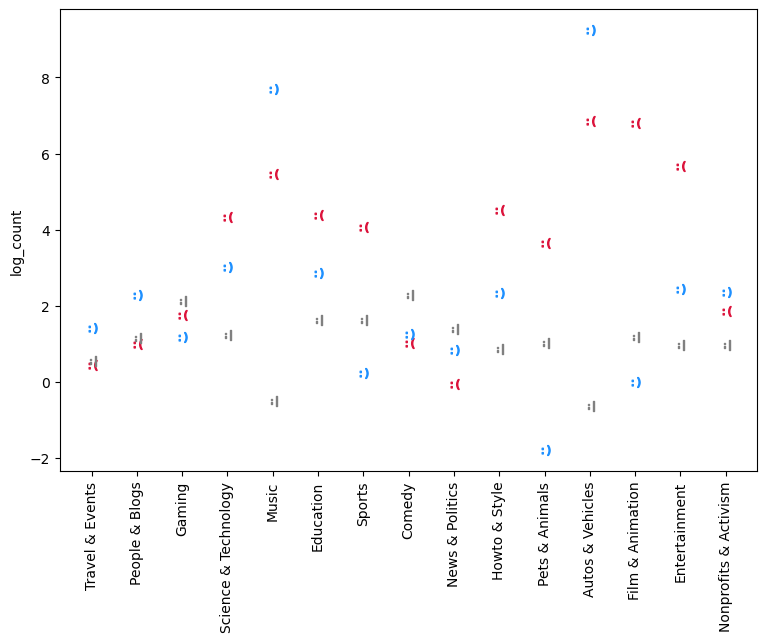


Linear regression for log_like_count


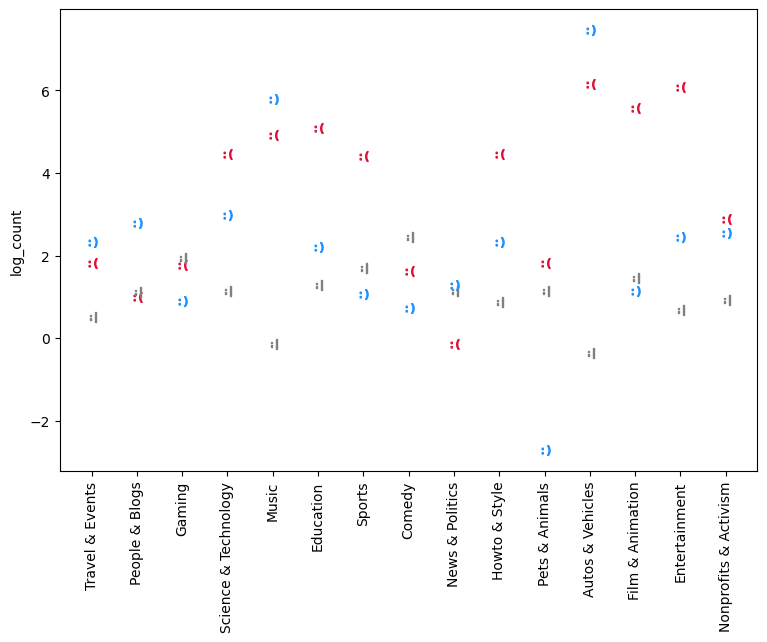


Linear regression for log_dislike_count


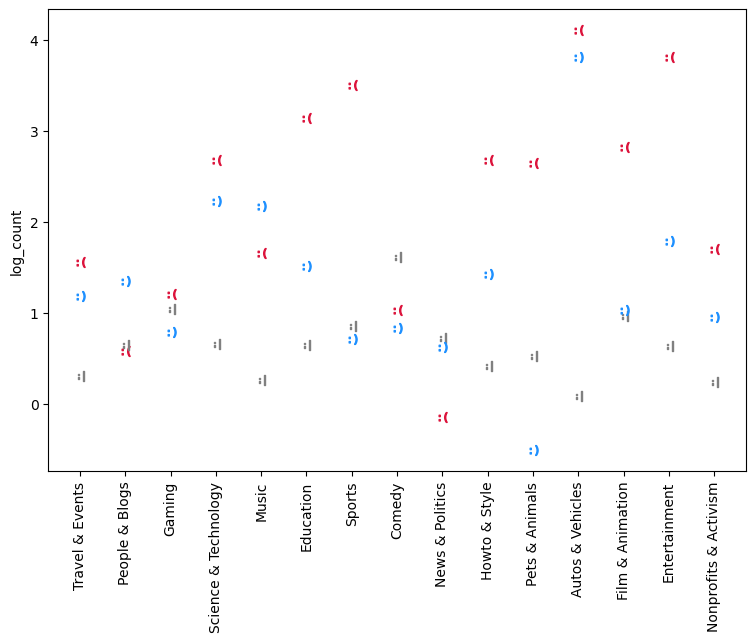

In [9]:
# Plot the regression parameters for various success factors

for success_f in success_factors:
    print(f'Linear regression for {success_f}')
    plot_regression(regression_for_success_factor[success_f])
    print('')

In [10]:
# Alternative: seaborn plot
'''
# Colors for the plot
palette_sentiment = {
    'sia_negative_description': 'crimson',
    'sia_neutral_description': 'gray',
    'sia_positive_description': 'dodgerblue',
    'Intercept': 'black'

}

# Drop p-values and `Intercept`, remove index
df_regression = df_regression['parameter']
df_regression = df_regression.drop('Intercept', axis=1)
df_regression = df_regression.reset_index()

# Convert the dataframe to long form, for seaborn plot
df_regression_melt = df_regression.melt('index', var_name='sentiment_type', value_name='sentiment_value')

# Plot
sns.scatterplot(
    data=df_regression_melt, 
    x='index', 
    y='sentiment_value', 
    hue='sentiment_type',
    s=40,
    marker='D',
    palette=palette_sentiment,
    #aspect=2,
    #jitter=False,  # for vertically aligned datapoints in each category
    alpha=0.8
)
plt.xticks(rotation=90)
plt.show()
'''
' '

' '

## Evolution of channels with negativity [[Victor]]

## What does successful negativity look like?

### Most used words: the vocabulary of videos that are negative and successful (for different categories) [[Maj]]

Make 'histogram' of words in title/desc for videos that are very negative and have lots of success (maybe do it for each category). Example:

https://ldrame21.github.io/metoo-media-impact/#data-story-title

### Try to extract topics from negative and successful videos